# Compare Snow depth Maps Example

**Goal**: Use the USGS Snow off and the ASO snow off to calculate a snow depth raster. Compare them.

**Approach**: 

1. Get a location and make a perimeter
2. 

## Process:

### Step 1: Get a buffered circle centered on a pit

In [1]:
from snowxsql.db import get_db
from snowxsql.data import ImageData, SiteData
from rasterio.plot import show

from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster
from geoalchemy2.shape import to_shape, from_shape
import geopandas as gpd
from snowxsql.conversions import raster_to_rasterio, points_to_geopandas, query_to_geopandas, crop, resample
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import rasterio.mask
import tempfile

# Pit Site Identifier of interest
site_id = '1S1'

# Distance around the pit to collect data in meters
buffer_dist = 100

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)
datasets = []

# Grab our sites details by site id
q = session.query(SiteData).filter(SiteData.site_id==site_id)
sites = q.all()

# Grab the pit location from a single layer
p = to_shape(sites[0].geom)

# Build a polygon  using the buffer distance 
x1 = p.x - buffer_dist
y1 = p.y - buffer_dist
x2 = p.x + buffer_dist
y2 = p.y + buffer_dist
buffered_pit = from_shape(Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]), srid=26912)


### Step 2. Gather the Snow on/off rasters within the Buffered Pit 

In [2]:
def get_raster(session, data_type, surveyor, polygon):
    '''
    
    '''
    # Grab the rasters, union them and convert them as tiff when done
    q = session.query(func.ST_AsTiff(func.ST_Union(ImageData.raster, type_=Raster)))

    # Only grab rasters that are the bare earth DEM from QSI
    q = q.filter(ImageData.type == data_type)
    q = q.filter(ImageData.surveyors == surveyor)
    
    # And grab rasters touching the polygon
    q = q.filter(gfunc.ST_Intersects(ImageData.raster, polygon))

    # Execute the query
    rasters = q.all()

    # Get the rasterio object of the raster
    return raster_to_rasterio(session, rasters)[0]

crop:
SRC = (1000, 2000) --> DST = (1, 400, 400)
(400, 400)


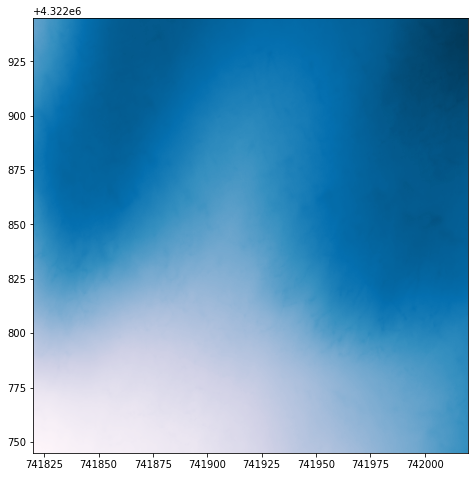

In [3]:
# Grab the rasters, union them and convert them as tiff when done
session.rollback()

snow_on = get_raster(session, 'bare earth digital elevation models', 'Quantum Spatial Inc.', buffered_pit)

buffered_pit_df = gpd.GeoDataFrame({'geometry':[to_shape(buffered_pit)]})
snow_on = crop(snow_on, buffered_pit)
print(snow_on.shape)

fig, ax = plt.subplots(1,1, figsize=(8,8))
show(snow_on.read(1), ax=ax, transform=snow_on.transform, cmap='PuBu')


In [4]:
# Get the shape of the raster for clipping and resampling
b = snow_on.bounds
x1, y1, x2, y2 = b[0], b[1], b[2], b[3]
box = from_shape(Polygon([[x1,y1],[x1,y2],[x2,y2],[x2,y1]]), srid=26912)
print(to_shape(box))

POLYGON ((741820 4322745, 741820 4322945, 742020 4322945, 742020 4322745, 741820 4322745))


In [5]:
usgs_snow_off = get_raster(session, 'snow off digital elevation model', 'USGS', box)
aso_snow_off = get_raster(session, 'snow off digital elevation model', 'Airborne Snow Observatory', box)

# Crop
rasters = {}
print('\nUSGS')
rasters['usgs'] = crop(resample(usgs_snow_off, snow_on.res), box, invert=False)
print('\nASO')
rasters['aso'] = crop(resample(aso_snow_off, snow_on.res), box, invert=False)
df = gpd.GeoDataFrame({'geometry':[to_shape(box)]})


USGS
resample:
SRC res = (1.0, 1.0) -- > DST res = (0.5, 0.5)
scaling_x Factor --> 0.5
scaling_y Factor --> 0.5
SRC Dims = (500, 1000) --> DST dims = (1000, 2000)
crop:
SRC = (2000, 1000) --> DST = (1, 800, 200)

ASO
resample:
SRC res = (2.999870551816784, 2.999870551816784) -- > DST res = (0.5, 0.5)
scaling_x Factor --> 0.16667385854272598
scaling_y Factor --> 0.16667385854272598
SRC Dims = (500, 500) --> DST dims = (2999, 2999)
crop:
SRC = (2999, 2999) --> DST = (1, 400, 401)


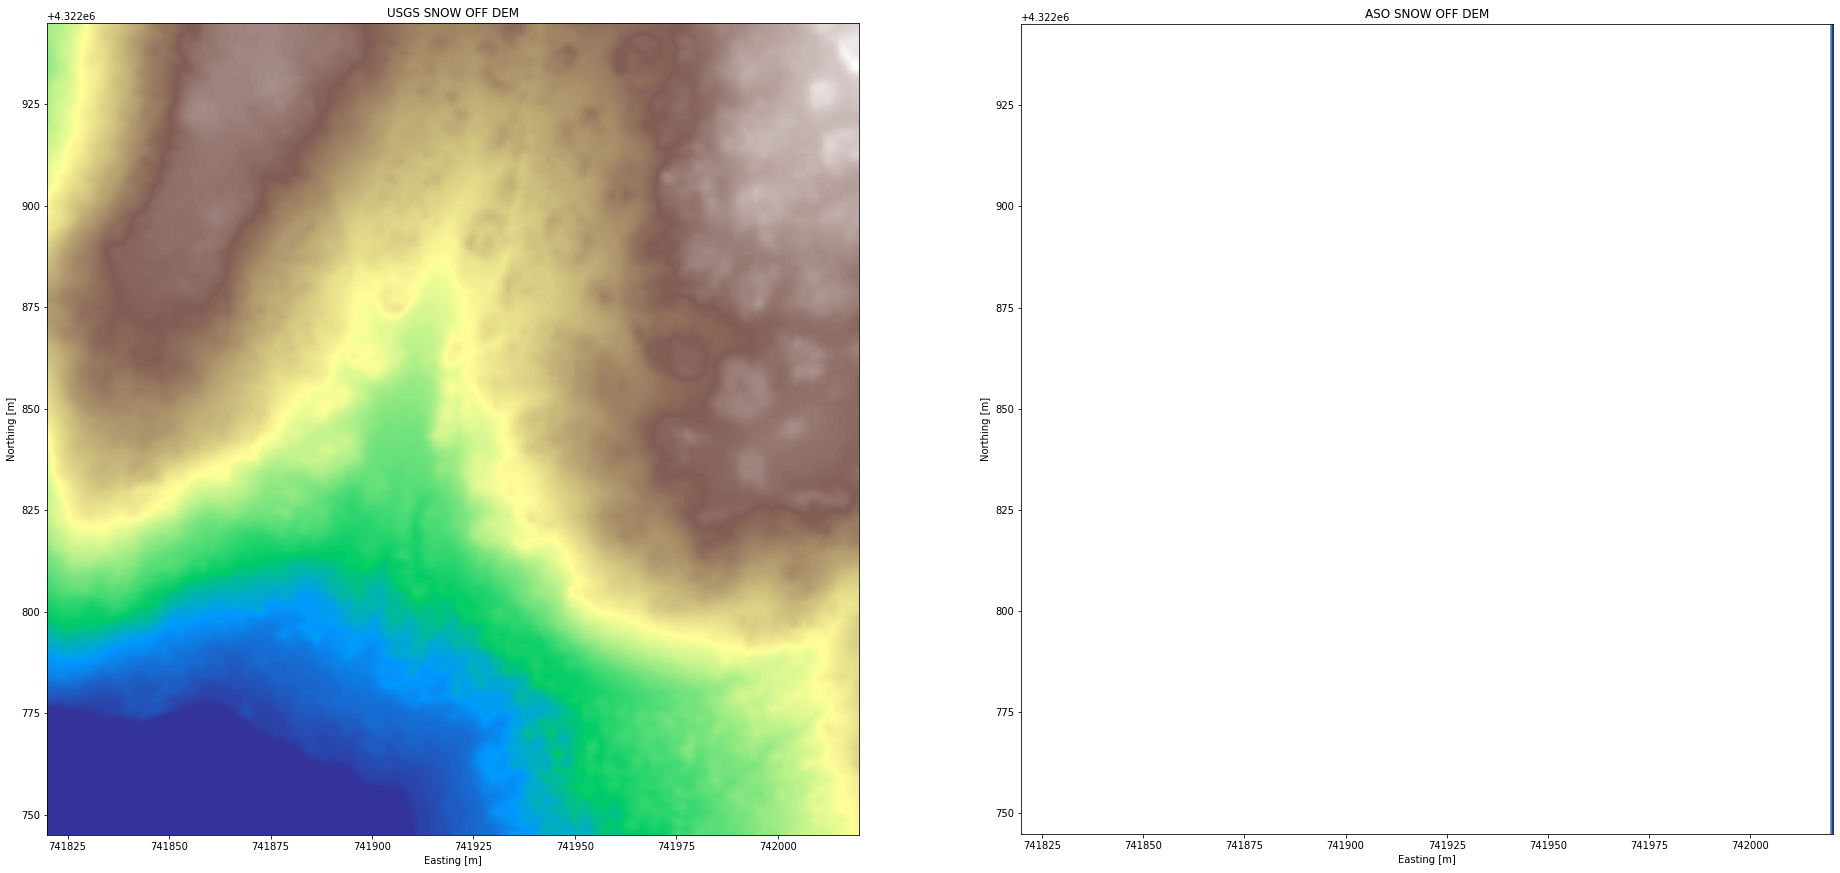

In [6]:
# Plot these to confirm we have something similar
fig, axes = plt.subplots(1,len(rasters.keys()), figsize=(32,16))
i = 0 

for name, dst in rasters.items():
    if name == 'difference':
        cmap = 'coolwarm'
    else:
        cmap = 'terrain'
    # pic = axes[i].imshow(img[0], cmap=cmap)
    # fig.colorbar(pic, ax=axes[i])
    #im = axes[i].imshow(img[0], cmap=cmap, interpolation=None)
    show(dst.read(1), transform=dst.transform, cmap=cmap, ax=axes[i])
#     # Don't use scientific notation on the axis ticks
#     axes[i].ticklabel_format(style='plain', useOffset=False)

    # Add x/y labels, a title, a legend and avoid overlapping labels
    axes[i].set_xlabel('Easting [m]')
    axes[i].set_ylabel('Northing [m]')
    axes[i].set_title('{} SNOW OFF DEM'.format(name.upper()))
#     buffered_pit_df.plot(ax=axes[i], alpha=0.1, edgecolor='black')
    i += 1
    
# fig.colorbar(im, ax=axes.ravel().tolist())

### Step . Create the Snow Depth Maps

In [7]:
snow_dem = snow_on.read(1)
usgs_depths = snow_dem - rasters['usgs'].read(1)
# aso_depths = snow_dem - aso_dem_resized

# diff = aso_depths - usgs_depths

ValueError: operands could not be broadcast together with shapes (400,400) (800,200) 

### Step 5. Plot it

In [ ]:
# Create a single plot to add everything to
data = {'USGS':(usgs_depths, snow_on.transform)}

h = 20
nplots = len(data.keys())
fig, axes = plt.subplots(1, nplots, figsize=(2 * h, h))

i = 0 

# Plot the Snow Depths
for name, d in data.items():
    img = d
#   transform = d[1]
    ax = axes[i]
    show(img, ax=ax, cmap='PuBu')

    # Don't use scientific notation on the axis ticks
    ax.ticklabel_format(style='plain', useOffset=False)

    # Add x/y labels, a title, a legend and avoid overlapping labels
    ax.set_xlabel('Easting [m]')
    ax.set_ylabel('Northing [m]')
    ax.set_title(name)
    ax.legend()
    i += 1
    
plt.tight_layout()
